## Fast.AI Test Drive: Brand and Product Identifier

'Style' data set by Olga Belitskaya hosted at Kaggle.com on 8 March 2018; 
wget https://www.kaggle.com/olgabelitskaya/style-color-images/downloads/style-color-images.zip

In [1]:
%reload_ext autoreload
%autoreload 2 
%matplotlib inline

In [2]:
from fastai.imports import * 

In [3]:
from fastai.conv_learner import *
from fastai.transforms import * 
from fastai.model import * 
from fastai.dataset import * 
from fastai.sgdr import * 
from fastai.plots import * 

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

### 1. Data Augmentation

In [6]:
PATH = "data/style/" 
!rm -rf {PATH}tmp 
os.listdir(PATH)

['models',
 'StyleColorImages.h5',
 'train894',
 'style.zip',
 'styletags.csv',
 'styleproduct.csv',
 'test0',
 '.ipynb_checkpoints',
 'stylebrand.csv',
 'style.csv']

In [7]:
label_csv = f'{PATH}styleproduct.csv'
n = len(list(open(label_csv)))-1 
val_idxs = get_cv_idxs(n)
print('Quantity of data:',n), print('Data for validation:',len(val_idxs));

Quantity of data: 894
Data for validation: 178


In [8]:
label_df = pd.read_csv(label_csv) 
print('Sample content of StyleProduct.csv label file:')
label_df.head()

Sample content of StyleProduct.csv label file:


,file,product_name
0,0_0_001.png,shoes
1,0_0_002.png,shoes
2,0_0_003.png,shoes
3,0_0_004.png,shoes
4,0_0_005.png,shoes


In [9]:
label_df.pivot_table(index='product_name', 
    aggfunc=len).sort_values('file', ascending=True)

,file
product_name,
necklace,48
bracelet,49
boots,60
nail polish,61
earrings,63
lipstick,66
watches,78
ring,88
shoes,188


In [10]:
PATH = 'data/style/train894/'
len(os.listdir(PATH))

896

In [11]:
files = os.listdir(f'{PATH}')[:3] 
files

['2_1_006.png', '2_2_002.png', '2_0_011.png']

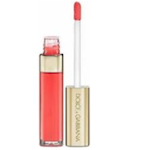

In [12]:
fn = f'{PATH}{files[0]}' 
Image.open(fn)

In [13]:
img = PIL.Image.open(fn)
img.size

(150, 150)

In [14]:
sz = 224 
PATH2 = 'data/style/' 
bs = 8 
arch = resnet34 
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH2, 'train894', 
    f'data/style/styleproduct.csv', val_idxs=val_idxs, tfms=tfms, bs=bs)

In [15]:
size_d = {k: PIL.Image.open(PATH2+k).size for k in data.trn_ds.fnames}

In [16]:
row_sz, col_sz = list(zip(*size_d.values())) 
row_sz=np.array(row_sz); col_sz=np.array(col_sz) 
row_sz[:5], col_sz[:5]

(array([150, 150, 150, 150, 150]), array([150, 150, 150, 150, 150]))

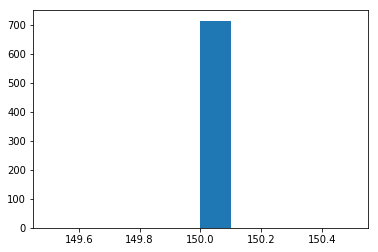

In [17]:
plt.hist(row_sz);

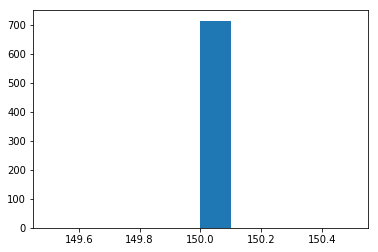

In [18]:
plt.hist(col_sz);

(array([  0.,   0.,   0.,   0.,   0., 715.,   0.,   0.,   0.,   0.]),
 array([149.5, 149.6, 149.7, 149.8, 149.9, 150. , 150.1, 150.2, 150.3, 150.4, 150.5]),
 <a list of 10 Patch objects>)

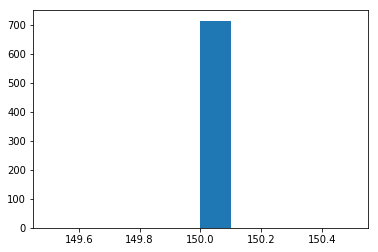

In [19]:
plt.hist(col_sz[row_sz])

In [20]:
len(data.trn_ds)

716

In [21]:
len(data.classes), data.classes #noted nail

(11,
 ['boots',
  'bracelet',
  'earrings',
  'handbag',
  'lipstick',
  'nail',
  'necklace',
  'polish',
  'ring',
  'shoes',
  'watches'])

In [22]:
sz = 64 
bs = 4 
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH2, 'train894', 
    f'data/style/styleproduct.csv', val_idxs=val_idxs, tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(arch, data, precompute=True) 

100%|██████████| 45/45 [00:01<00:00, 37.77it/s]


In [23]:
%time learn.fit(1e-2,3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.363206   0.218049   0.940909  
    1      0.215737   0.157879   0.942424                     
    2      0.196565   0.14699    0.941919                     

CPU times: user 3.09 s, sys: 626 ms, total: 3.71 s
Wall time: 3.33 s


[0.14698951, 0.9419191943274604]

= Epoch   100% 3/3 00:03<00:00, 1.11s/it

epoch      trn_loss   val_loss   <lambda>                     
    0      0.363206   0.218049   0.940909  
    1      0.215737   0.157879   0.942424                     
    2      0.196565   0.14699    0.941919                     

CPU times: user 3.09 s, sys: 626 ms, total: 3.71 s
Wall time: 3.33 s

0.14698951, 0.9419191943274604 =.

### 2. Learning Rate Experiment

In [24]:
%time lrf=learn.lr_find() 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 151/179 [00:00<00:00, 192.13it/s, loss=0.675]
CPU times: user 699 ms, sys: 171 ms, total: 870 ms            
Wall time: 835 ms


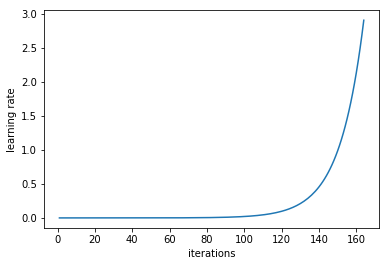

In [25]:
learn.sched.plot_lr()

In [26]:
len(data.trn_ds)/bs

179.0

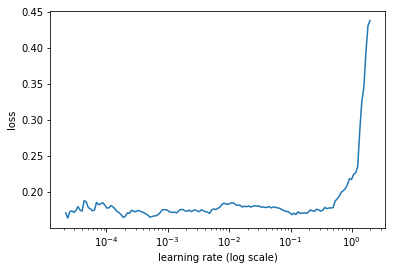

In [27]:
learn.sched.plot()

In [28]:
lr = 0.08 #1e-2 =0.01 

### 3. Train last layer from precomputed weights for 2 epochs

In [29]:
%time learn.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.223379   0.153998   0.944444  
    1      0.228503   0.165283   0.938384                     

CPU times: user 1.54 s, sys: 372 ms, total: 1.92 s
Wall time: 1.69 s


[0.16528252, 0.9383838454882304]

= Epoch   100% 2/2 00:01<00:00, 1.19it/s

epoch      trn_loss   val_loss   <lambda>                     
    0      0.223379   0.153998   0.944444  
    1      0.228503   0.165283   0.938384                     

CPU times: user 1.54 s, sys: 372 ms, total: 1.92 s
Wall time: 1.69 s

 0.16528252, 0.9383838454882304 =.

In [30]:
sz = 80
bs = 8
lr = 0.01
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, 
        max_zoom=1.1, pad=sz//8)
data = ImageClassifierData.from_csv(PATH2, 'train894', 
    f'data/style/styleproduct.csv', val_idxs=val_idxs, tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(arch, data, precompute=True) 

100%|██████████| 23/23 [00:04<00:00,  4.73it/s]


In [31]:
%time lrf=learn.lr_find() 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.950371   5.308286   0.798419  

CPU times: user 568 ms, sys: 142 ms, total: 710 ms
Wall time: 610 ms


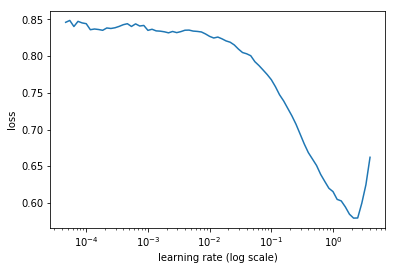

In [32]:
learn.sched.plot()

In [34]:
lr = 0.6

In [35]:
%time learn.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.426289   0.217696   0.939229  
    1      0.424443   0.26792    0.938735                   

CPU times: user 1.14 s, sys: 267 ms, total: 1.41 s
Wall time: 1.23 s


[0.26792014, 0.9387351818706678]

= Epoch   100% 2/2 00:01<00:00, 1.63it/s

epoch      trn_loss   val_loss   <lambda>                   
    0      0.426289   0.217696   0.939229  
    1      0.424443   0.26792    0.938735                   

CPU times: user 1.14 s, sys: 267 ms, total: 1.41 s
Wall time: 1.23 s

0.26792014, 0.9387351818706678 =. 

### 4. Drill in last layer

In [36]:
%time learn.fit(lr, 3, cycle_len=2, cycle_mult=2) 

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.346677   0.1883     0.955534  
    1      0.219557   0.120047   0.967391                   
    2      0.312329   0.272365   0.94664                    
    3      0.318658   0.199637   0.962945                   
    4      0.234046   0.110547   0.972332                   
    5      0.139773   0.111652   0.968379                   
    6      0.288079   0.190046   0.964427                   
    7      0.40196    0.238985   0.957016                   
    8      0.427118   0.370071   0.954051                   
    9      0.384313   0.273802   0.95504                    
    10     0.300219   0.149907   0.961957                   
    11     0.207256   0.197656   0.963439                   
    12     0.154314   0.176451   0.967391                   
    13     0.156673   0.163635   0.963439                   

CPU times: user 7.43 s, sys: 1.88 s, total: 9.31 s
Wall time: 7.97 s


[0.16363482, 0.963438736355823]

= Epoch   100% 14/14 00:07<00:00, 1.76it/s

epoch      trn_loss   val_loss   <lambda>                   
    0      0.346677   0.1883     0.955534  
    1      0.219557   0.120047   0.967391                   
    2      0.312329   0.272365   0.94664                    
    3      0.318658   0.199637   0.962945                   
    4      0.234046   0.110547   0.972332                   
    5      0.139773   0.111652   0.968379                   
    6      0.288079   0.190046   0.964427                   
    7      0.40196    0.238985   0.957016                   
    8      0.427118   0.370071   0.954051                   
    9      0.384313   0.273802   0.95504                    
    10     0.300219   0.149907   0.961957                   
    11     0.207256   0.197656   0.963439                   
    12     0.154314   0.176451   0.967391                   
    13     0.156673   0.163635   0.963439                   

CPU times: user 7.43 s, sys: 1.88 s, total: 9.31 s
Wall time: 7.97 s

0.16363482, 0.963438736355823 =.

### 5. Unfreeze all layers

In [37]:
learn.unfreeze() 
learn.precompute=False 

### 6. Set early layers learning rate up to 3x lower 

In [38]:
lrs = np.array([lr/3, lr/2, lr]) 
%time learn.fit(lrs, 3, cycle_len=2, cycle_mult=2) 

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.349526   0.359484   0.949111  
    1      0.274422   0.218669   0.957016                  
    2      0.401824   0.243905   0.953557                  
    3      0.392282   0.51677    0.94417                   
    4      0.297713   0.382914   0.955534                  
    5      0.238447   0.229018   0.965909                  
    6      0.422464   0.458586   0.940217                  
    7      0.57547    0.621988   0.914526                  
    8      0.549183   0.369743   0.934289                  
    9      0.408851   0.214423   0.960474                  
    10     0.290511   0.138447   0.961957                  
    11     0.213935   0.13233    0.958004                  
    12     0.176884   0.180014   0.958004                  
    13     0.163965   0.134584   0.962945                  

CPU times: user 4min 19s, sys: 1min 36s, total: 5min 56s
Wall time: 5min 35s


[0.13458382, 0.9629446656807609]

= Epoch   100% 14/14    05:35<00:00, 23.93s/it

epoch      trn_loss   val_loss   <lambda>                  
    0      0.349526   0.359484   0.949111 c1 
    1      0.274422   0.218669   0.957016                  
    2      0.401824   0.243905   0.953557 c2                 
    3      0.392282   0.51677    0.94417                   
    4      0.297713   0.382914   0.955534                  
    5      0.238447   0.229018   0.965909                  
    6      0.422464   0.458586   0.940217 c3                  
    7      0.57547    0.621988   0.914526                  
    8      0.549183   0.369743   0.934289                  
    9      0.408851   0.214423   0.960474                  
    10     0.290511   0.138447   0.961957                  
    11     0.213935   0.13233    0.958004                  
    12     0.176884   0.180014   0.958004                  
    13     0.163965   0.134584   0.962945                  

CPU times: user 4min 19s, sys: 1min 36s, total: 5min 56s
Wall time: 5min 35s

0.13458382, 0.9629446656807609 =. 

### 7. Learning Rate Augmentation 

In [48]:
sz = 112 
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, 
                        max_zoom=1.11, pad=sz//8)
def get_augs(): 
    data = ImageClassifierData.from_csv(PATH2, 'train894', 
                                        f'data/style/styleproduct.csv', 
                                        val_idxs=val_idxs, tfms=tfms, bs=bs) 
    x,_ = next(iter(data.aug_dl)) 
    return data.trn_ds.denorm(x)[1] 

In [49]:
ims = np.stack([get_augs() for i in range(6)])
learn.freeze() 
learn = ConvLearner.pretrained(arch, data, precompute=True) 

In [50]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.879766   6.35605    0.748024  



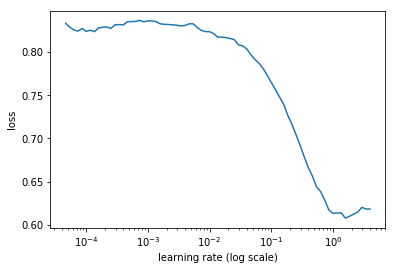

In [51]:
learn.sched.plot() 

In [52]:
lr = 0.5

In [53]:
%time learn.fit(lr, 2) 

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.419875   0.229437   0.948123  
    1      0.297987   0.167586   0.956522                   

CPU times: user 940 ms, sys: 261 ms, total: 1.2 s
Wall time: 1.05 s


[0.1675862, 0.956521741721941]

= Epoch   100% 2/2    00:01<00:00, 1.92it/s

epoch      trn_loss   val_loss   <lambda>                   
    0      0.419875   0.229437   0.948123  
    1      0.297987   0.167586   0.956522                   

CPU times: user 940 ms, sys: 261 ms, total: 1.2 s
Wall time: 1.05 s

 0.1675862, 0.956521741721941 =.

In [54]:
learn.unfreeze()

### 8. Train full network into over-fitting (Loss: Training > Validation)

In [55]:
%time learn.fit(lr, 3, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.243958   0.159491   0.956522  
    1      0.169745   0.115074   0.963933                  
    2      0.216098   0.148599   0.952569                  
    3      0.21294    0.110981   0.959486                  
    4      0.181713   0.094524   0.965909                  
    5      0.139989   0.093498   0.965415                  
    6      0.199006   0.165615   0.945158                  
    7      0.23835    0.134804   0.960474                  
    8      0.230056   0.134526   0.953557                  
    9      0.195473   0.094308   0.964921                  
    10     0.1523     0.07768    0.967885                  
    11     0.119896   0.075757   0.970356                  
    12     0.10463    0.076996   0.971838                   
    13     0.103204   0.076321   0.972826                  

CPU times: user 4min 24s, sys: 1min 39s, total: 6min 4s
Wall time: 5min 43s


[0.07632064, 0.9728260895480281]

= Epoch   100% 14/14   05:43<00:00, 24.53s/it 

epoch      trn_loss   val_loss   <lambda>                  
    0      0.243958   0.159491   0.956522  
    1      0.169745   0.115074   0.963933                  
    2      0.216098   0.148599   0.952569                  
    3      0.21294    0.110981   0.959486                  
    4      0.181713   0.094524   0.965909                  
    5      0.139989   0.093498   0.965415                  
    6      0.199006   0.165615   0.945158                  
    7      0.23835    0.134804   0.960474                  
    8      0.230056   0.134526   0.953557                  
    9      0.195473   0.094308   0.964921                  
    10     0.1523     0.07768    0.967885                  
    11     0.119896   0.075757   0.970356                  
    12     0.10463    0.076996   0.971838                   
    13     0.103204   0.076321   0.972826                  

CPU times: user 4min 24s, sys: 1min 39s, total: 6min 4s
Wall time: 5min 43s

 0.07632064, 0.9728260895480281 =. 

In [56]:
learn.save('112_style')

In [57]:
learn.load('112_style')

In [59]:
sz = 144 
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, 
                        max_zoom=1.11, pad=sz//8)
ims = np.stack([get_augs() for i in range(6)])
learn.freeze() 
lrs = np.array([lr*9, lr*3, lr]) 

In [61]:
%time learn.fit(lrs, 3, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.127684   0.08809    0.969368  
    1      0.117745   0.081414   0.971838                  
    2      0.145087   0.108656   0.967391                  
    3      0.177344   0.110184   0.963933                  
    4      0.141962   0.089825   0.972826                  
    5      0.105618   0.08905    0.969368                  
    6      0.159656   0.112466   0.967391                  
    7      0.218745   0.129617   0.960968                  
    8      0.202301   0.144952   0.962451                  
    9      0.168143   0.128476   0.967391                  
    10     0.157809   0.087549   0.969862                  
    11     0.129888   0.07073    0.972332                  
    12     0.089692   0.080659   0.968874                   
    13     0.091077   0.078092   0.971344                   

CPU times: user 4min 19s, sys: 1min 37s, total: 5min 56s
Wall time: 5min 35s


[0.078092486, 0.9713438749313354]

Final two trainings presents loss of 0.07 and accuracy 97% 

= Epoch   100% 14/14   05:35<00:00, 23.96s/it 

epoch      trn_loss   val_loss   <lambda>                   
    0      0.127684   0.08809    0.969368  
    1      0.117745   0.081414   0.971838                  
    2      0.145087   0.108656   0.967391                  
    3      0.177344   0.110184   0.963933                  
    4      0.141962   0.089825   0.972826                  
    5      0.105618   0.08905    0.969368                  
    6      0.159656   0.112466   0.967391                  
    7      0.218745   0.129617   0.960968                  
    8      0.202301   0.144952   0.962451                  
    9      0.168143   0.128476   0.967391                  
    10     0.157809   0.087549   0.969862                  
    11     0.129888   0.07073    0.972332                  
    12     0.089692   0.080659   0.968874                   
    13     0.091077   0.078092   0.971344                   

CPU times: user 4min 19s, sys: 1min 37s, total: 5min 56s
Wall time: 5min 35s

 0.078092486, 0.9713438749313354 =.


### 9. Review

In [62]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)
probs = np.mean(np.exp(preds),0)

In [63]:
probs

array([1.11123, 1.03541, 1.05582, 1.37896, 1.11451, 1.10762, 1.08639, 1.10782, 1.08904, 1.34572, 1.12057],
      dtype=float32)

In [64]:
preds

array([[0.     , 0.00006, 0.00003, ..., 0.00126, 0.99927, 0.     ],
       [0.00777, 0.00125, 0.0218 , ..., 0.00039, 0.94615, 0.00002],
       [0.03888, 0.00045, 0.00189, ..., 0.00137, 0.93948, 0.     ],
       ...,
       [0.98935, 0.00014, 0.00215, ..., 0.     , 0.00016, 0.00001],
       [0.0112 , 0.01061, 0.02435, ..., 0.04131, 0.00707, 0.00287],
       [0.01082, 0.00454, 0.05569, ..., 0.00337, 0.01098, 0.00019]], dtype=float32)

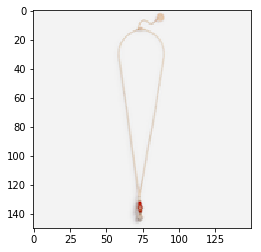

In [65]:
files = os.listdir(f'{PATH}')[:895]
item = 301
plt.imshow(plt.imread(f'{PATH}{files[item]}'));

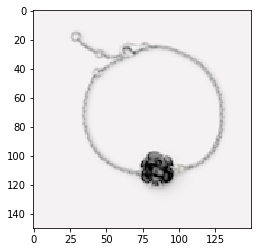

In [66]:
item = 300; plt.imshow(plt.imread(f'{PATH}{files[item]}'));

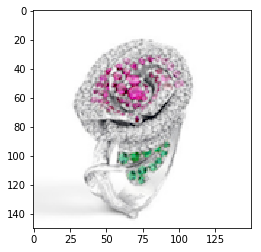

In [67]:
item = 200; plt.imshow(plt.imread(f'{PATH}{files[item]}')); 

Could an average man identify necklace vs braclet, or ring vs ear rings  from two dimension image size 150 x 150 pixels without any misses? 

This Fast.AI using ResNet34 can identify products and accessories with up to 97% accuracy. 

Cloud computer and GPU sponsored by Google Cloud.  
Fast.AI by Jeremy Howard and Rachel Thomas, the Data Institute, USFCA.  
Yap Jia Qing, James Lee, Desmon, Yen Ping, Han Chong, Rou En, Hafid at Nurture.Ai.  
Venue sponsorship by Mindvalley and NEXT Academy.  
And my friends Choy Hon Yoong and Muhammad Danial bin Rusdi.  

This artificial intelligence was trained by Khoo Kah Chin on 8 March 2018.  

# Thank you to the sponsors and organizers.